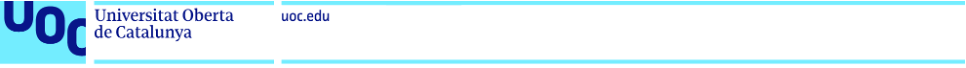

# Comparativa entre redes neuronales convolucionales y redes antagónicas generativas para el mejoramiento de la resolución de imágenes


Autor: **Carlos J. Guzmán Güell**<br>
Plan de Estudios: Grado en Ingeniería Informática<br>
Área del trabajo final: Inteligencia Artificial

Consultor: **Joan M. Núñez Do Río**<br>
Profesor responsable de la asignatura: **Dr. Xavier Baró Solé**

---

# Arquitectura CNN

In [1]:
# ------------------------------------------------------------------------------
# Imports
# ------------------------------------------------------------------------------
import os
import sys
import shutil
import time

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array

# ------------------------------------------------------------------------------
# Notebook constants
# ------------------------------------------------------------------------------
# Training constants
EPOCHS = 200
BATCH_SIZE = 8
model_name = f'cnn_for_superresolution_{EPOCHS}_epochs'

# Paths
path_to_repo = 'cnn-gan-superresolution'
path_to_models = f'{path_to_repo}/models/*.py'
path_to_utils = f'{path_to_repo}/utils/*.py'
path_to_dataset = f'{path_to_repo}/data/BSDS500/*'
path_to_results = f'{path_to_repo}/results'

#path_to_save_results = './cnn-results'
path_to_save_results = '/content/drive/MyDrive/UOC/Semestre 10/TFG - Inteligencia Artificial/cnn-gan-superresolution/cnn-results'

path_to_model = f'{path_to_save_results}/{model_name}.h5'
path_to_training_metrics = f'{path_to_save_results}/{model_name}_training_metrics.csv'
path_to_validation_metrics = f'{path_to_save_results}/{model_name}_validation_metrics.csv'

# ------------------------------------------------------------------------------
# Setup
# ------------------------------------------------------------------------------
if os.path.exists(path_to_repo):
    shutil.rmtree(path_to_repo)

!git clone https://github.com/Carlos0196/cnn-gan-superresolution.git

# Copy models to workspace
!cp $path_to_models .

# Copy utils to workspace
!cp $path_to_utils .

# Copy data to workspace
!cp -R $path_to_dataset .

# Scripts imports
from constants import *
from data_preprocessing import *
from visualization import *
from metrics import *
from generator import *

print('\n*******************************************')
print('**               Finished                **')
print('*******************************************')
print('\nCopied scripts:')
!ls | grep '**\.py' | nl

Cloning into 'cnn-gan-superresolution'...
remote: Enumerating objects: 713, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 713 (delta 51), reused 196 (delta 45), pack-reused 511
Receiving objects: 100% (713/713), 70.39 MiB | 14.84 MiB/s, done.
Resolving deltas: 100% (52/52), done.

*******************************************
**               Finished                **
*******************************************

Copied scripts:
     1	constants.py
     2	data_preprocessing.py
     3	discriminator.py
     4	generator.py
     5	metrics.py
     6	visualization.py




---


# Conjuntos de datos

Este estudio utiliza el conjunto de datos [BSDS500](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html).

En este apartado se separan las imágenes en:

1.   Conjunto de entrenamiento
2.   Conjunto de validación
3.   Conjunto de test

A cada conjunto se le ha realizado un preprocesamiento que consta de tomar las imágenes de alta resolución y redimensionarlas a imágenes de 300x300px, esto facilita su uso durante el entrenamiento.

Después de esto, se procede a realizar una redimensión nuevamente para obtener las imágenes de baja resolución de 100x100px que servirán de entrada para el modelo.

Finalmente, se puede observar una muestra de las imágenes ya tratadas.

Found 200 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Found 200 files belonging to 1 classes.


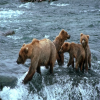

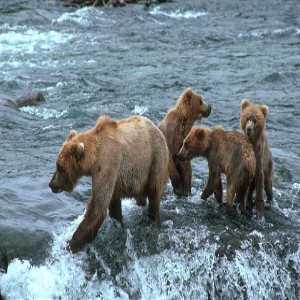

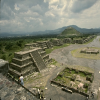

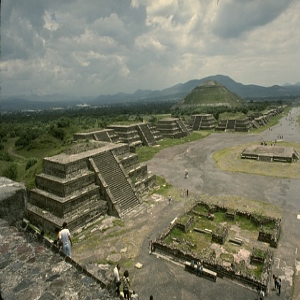

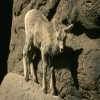

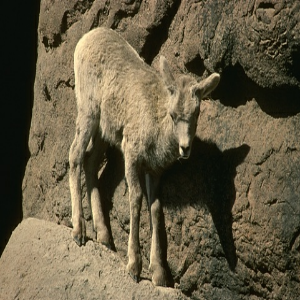

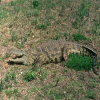

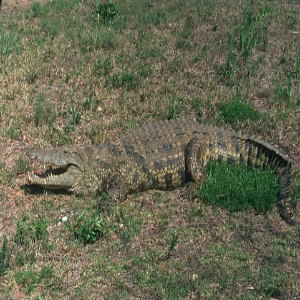

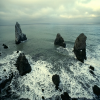

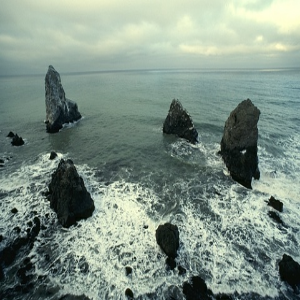

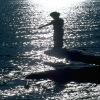

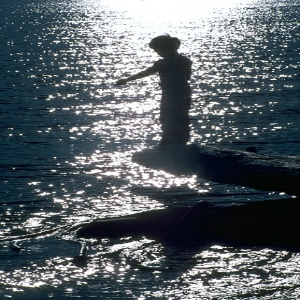

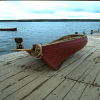

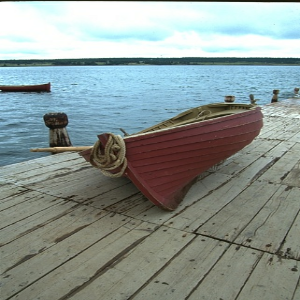

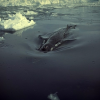

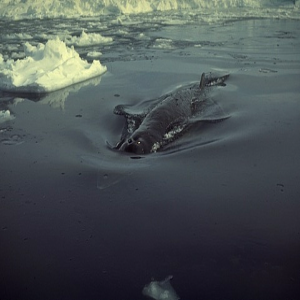

In [2]:
train_ds, valid_ds, test_ds = get_data_sets(BATCH_SIZE)

def show_batch():
  for batch in train_ds.take(1):
    for i in range(len(batch[0])):
      display(array_to_img(batch[0][i]))
      display(array_to_img(batch[1][i]))

show_batch()



---


# Función de pérdida y optimizador

Para la función de pérdida se utilizará MSE.

Para el optimizador, Adam con un *learning rate* de $\eta = 0.0002$

In [ ]:
# Generator loss
mse = tf.keras.losses.MeanSquaredError()
def loss(target_input, generated_img):
    return mse(target_input, generated_img)

# Genetator optimizer
optimizer = tf.keras.optimizers.Adam(1e-4)



---


# Entrenamiento

En este apartado se definen las funciones que harán el entrenamiento del modelo.

El entrenamiento incluye cálculo de métricas (MSE, SSIM y PSNR) que se almacenarán en un *dataframe* de la librería pandas. Además se mostrarán imágenes tras cada cuarto del entrenamiento, de esta manera se prodrá apreciar el estado entrenamiento.

In [ ]:
# This annotation causes the function to be "compiled".
@tf.function
def train_step(model, batch):
    low_res_images = batch[0]
    high_res_images = batch[1]

    with tf.GradientTape() as gen_tape:
        # Generate images
        output = model(low_res_images, training=True)

        # Calculate loss
        gen_loss = loss(high_res_images, output)

    # Optimize model
    model_gradients = gen_tape.gradient(gen_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(model_gradients, model.trainable_variables))

def train(train_ds, valid_ds, epochs, model):
  df_train = pd.DataFrame()
  df_valid = pd.DataFrame()

  # Epoch
  for epoch in range(epochs):
    start = time.time()

    ############################################################################
    #                             Training                                     #
    ############################################################################
    # Batch
    metrics_data = []
    for image_batch in train_ds:
      # Train on batch
      train_step(model, image_batch)
      
      # Batch metrics
      batch_metrics = calc_batch_metrics(model, image_batch)
      metrics_data.extend(batch_metrics)

    # Epoch metrics
    df_train_epoch = create_epoch_dataframe(f'EPOCH_{epoch+1}', DF_COLUMNS, metrics_data)
    df_train = pd.concat([df_train, df_train_epoch], axis=1)

    ############################################################################
    #                             Validation                                   #
    ############################################################################
    # Batch
    metrics_data = []
    for image_batch in valid_ds:
      # Batch metrics
      batch_metrics = calc_batch_metrics(model, image_batch)
      metrics_data.extend(batch_metrics)

    # Epoch metrics
    df_valid_epoch = create_epoch_dataframe(f'EPOCH_{epoch+1}', DF_COLUMNS, metrics_data)
    df_valid = pd.concat([df_valid, df_valid_epoch], axis=1)

    # Produce images after each training quarter
    if epochs >= 4:
      if (epoch + 1) % (epochs // 4) == 0:
        show_sample_images(epoch, model, path_to_save_results)

    ############################################################################
    #                             Statistics                                   #
    ############################################################################
    total_time = time.time()-start
    epoch_statistics(epoch, df_train_epoch, df_valid_epoch, total_time)

  # Produce images after the final epoch
  show_sample_images(epochs, model, path_to_save_results)

  return df_train, df_valid



---


# Modelo

Una vez definido el entrenamiento, se procede a crear una instancia del modelo CNN y se comienza el proceso.

El modelo a utilizar es el siguiente:

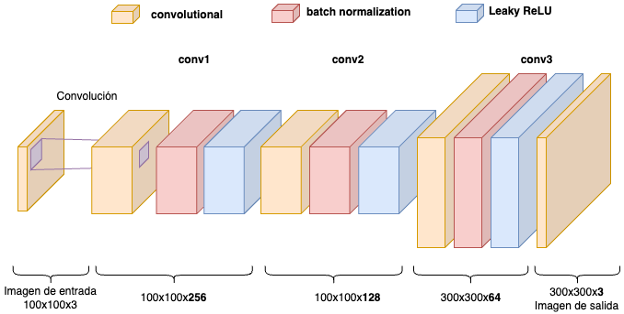

In [ ]:
# Create model
gen_model = make_generator_model()
gen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, None, None, 128)  3584      
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, None, None, 128)  512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, None, None, 128)   0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, None, None, 256)  295168    
 ranspose)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, None, None, 256)  1024      
 hNormalization)                                        

In [ ]:
# Start training
df_train, df_valid = train(train_ds, valid_ds, EPOCHS, gen_model)

Output hidden; open in https://colab.research.google.com to view.



---


# Almacenado del modelo y las métricas

In [ ]:
############################################################################
#                             Save model                                   #
############################################################################
gen_model.compile()
gen_model.save(path_to_model)
print("Model Saved!")

############################################################################
#                             Save metrics                                 #
############################################################################
df_train.to_csv(path_to_training_metrics)
df_valid.to_csv(path_to_validation_metrics)

print("Metrics Saved!")

Model Saved!
Metrics Saved!




---


# Carga de los modelos y métricas almacenadas


        EPOCH_1                                                       \
        BIC_MSE    GEN_MSE  BIC_SSIM  GEN_SSIM   BIC_PSNR   GEN_PSNR   
0    227.969800  4171.5030  0.756584  0.109824  24.552030  11.927876   
1     89.979770  5315.3535  0.838661  0.133921  28.589355  10.875481   
2    170.819380  3221.7727  0.840741  0.086565  25.805431  13.049854   
3    359.867070  2594.4893  0.501153  0.049096  22.569384  13.990284   
4    263.476000  4986.2330  0.762157  0.066105  23.923393  11.153080   
..          ...        ...       ...       ...        ...        ...   
195   96.396065  4811.0166  0.807279  0.115087  28.290210  11.308437   
196  136.580600  1408.0027  0.782521  0.158247  26.776913  16.644768   
197  151.507640  1107.7747  0.706429  0.190440  26.326458  17.686289   
198  238.784560  5871.2550  0.843035  0.088489  24.350740  10.443493   
199  279.172180  4192.6045  0.730091  0.082648  23.672081  11.905964   

        EPOCH_2                                 ... EPOCH_199 

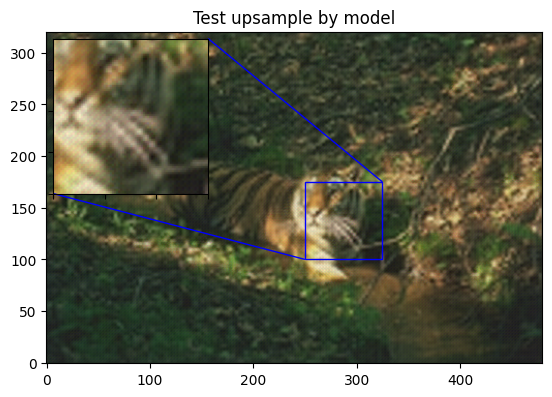

In [3]:
# Training metrics
number_of_epochs = 200
path_to_results_models = f'{path_to_results}/cnn_{number_of_epochs}'
loaded_df_train = pd.read_csv(f'{path_to_results_models}/metrics/cnn_for_superresolution_{number_of_epochs}_epochs_training_metrics.csv',header=[0,1], index_col=0)
print()
print(loaded_df_train)

# Validation metrics
loaded_df_valid = pd.read_csv(f'{path_to_results_models}/metrics/cnn_for_superresolution_{number_of_epochs}_epochs_validation_metrics.csv',header=[0,1], index_col=0)
print()
print(loaded_df_valid)

# Model
loaded_model = load_model(f'{path_to_results_models}/cnn_for_superresolution_{number_of_epochs}_epochs.h5')

hr_img = load_img('val/108070.jpg')
lr_img = downscale(hr_img)
gen_img = process_through_model(loaded_model, lr_img)
plot_results(
    gen_img,
    'Test upsample by model',
    [250, 325, 100, 175],
    '.',
    f'Test_loaded_model_epoch_{EPOCHS}'
)



---


# Métricas y resultados

In [ ]:
# funcion que en base al dataframe cree los graficos comparativos

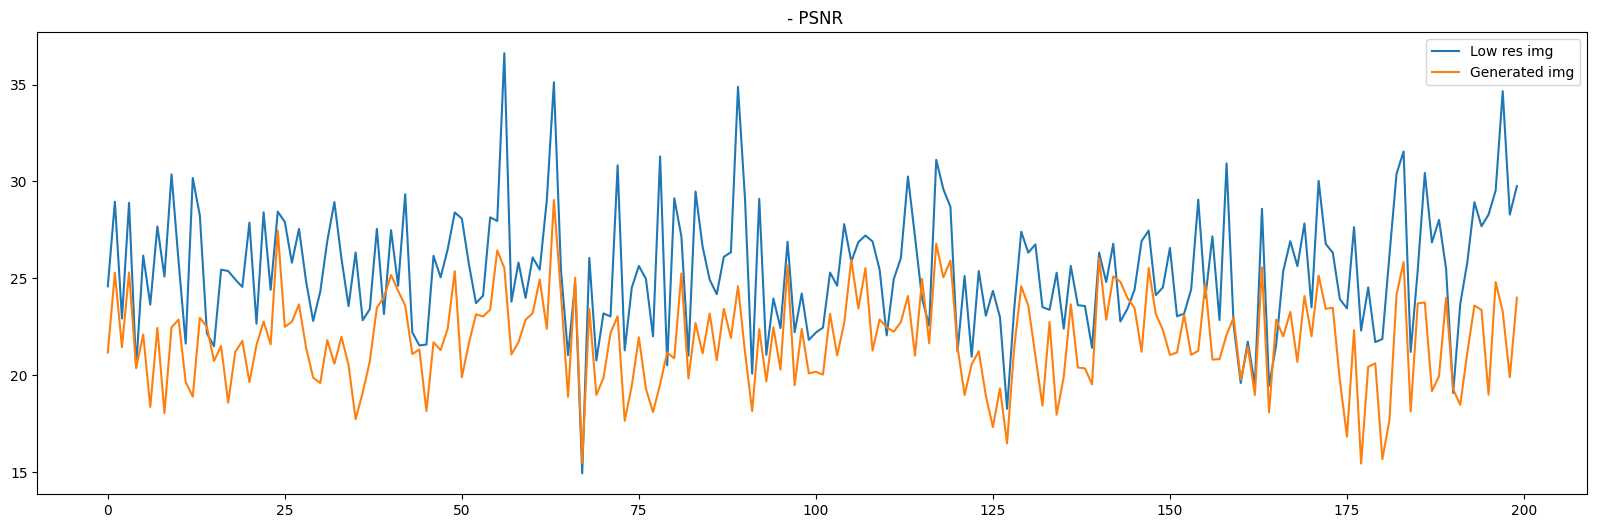

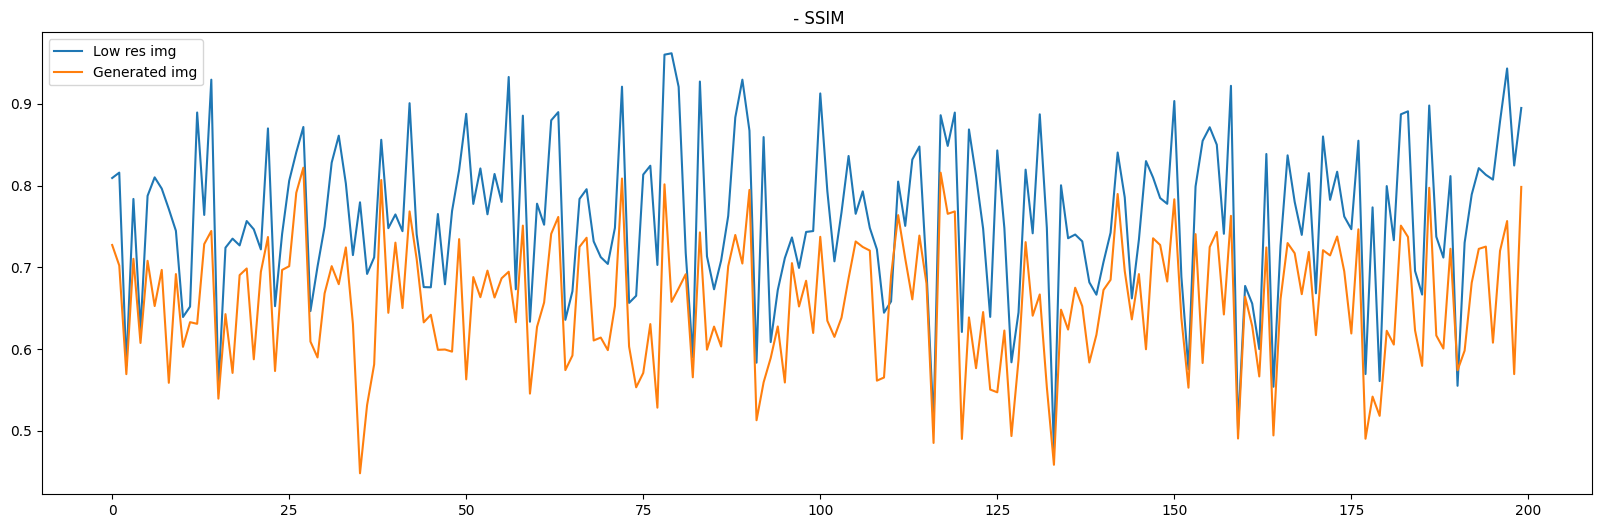

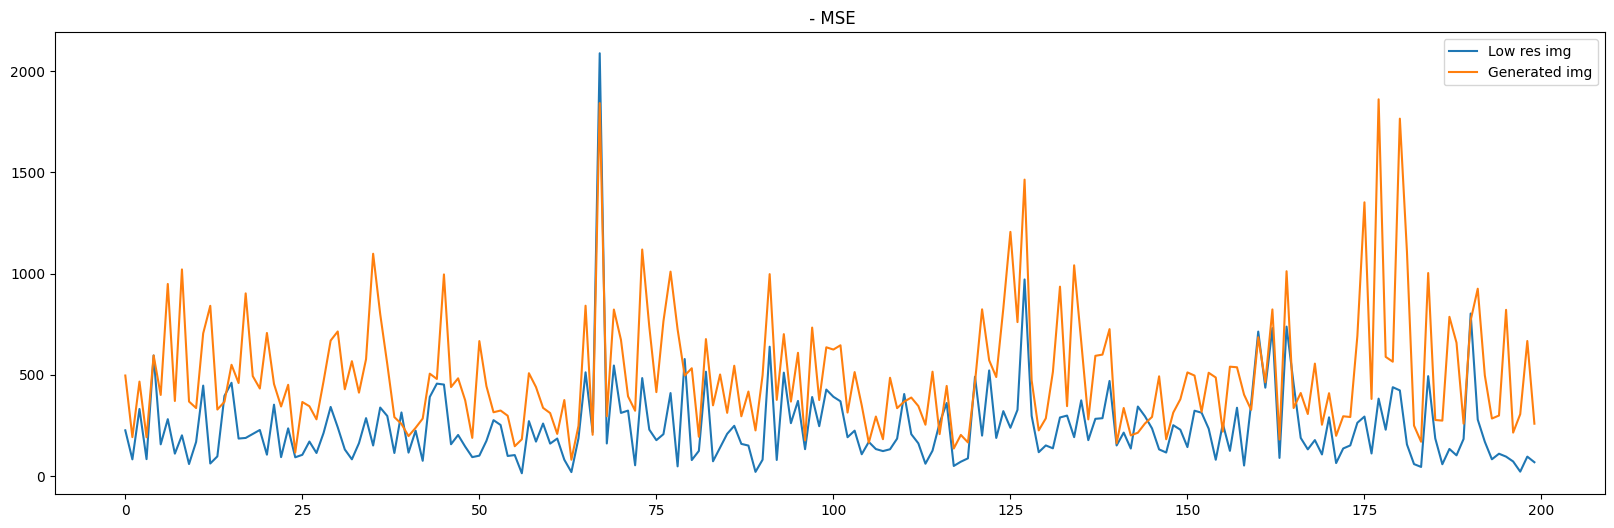

In [ ]:
import matplotlib.pyplot as plt

normalized_df=(loaded_df_train-loaded_df_train.mean())/loaded_df_train.std()

psnr_arr = [[], []]
psnr_arr[0] = loaded_df_train[f'EPOCH_{number_of_epochs}']['BIC_PSNR']
psnr_arr[1] = loaded_df_train[f'EPOCH_{number_of_epochs}']['GEN_PSNR']

ssim_arr = [[], []]
ssim_arr[0] = loaded_df_train[f'EPOCH_{number_of_epochs}']['BIC_SSIM']
ssim_arr[1] = loaded_df_train[f'EPOCH_{number_of_epochs}']['GEN_SSIM']

mse_arr = [[], []]
mse_arr[0] = loaded_df_train[f'EPOCH_{number_of_epochs}']['BIC_MSE']
mse_arr[1] = loaded_df_train[f'EPOCH_{number_of_epochs}']['GEN_MSE']

title = ''
# PSNR
arr = np.array(psnr_arr)

plt.figure(figsize=(20,6))
plt.title(f'{title} - PSNR')
plt.plot(np.arange(arr[0].size), arr[0], label = "Low res img")
plt.plot(np.arange(arr[1].size), arr[1], label = "Generated img")
plt.legend()
plt.show()

# SSIM
arr = np.array(ssim_arr)

plt.figure(figsize=(20,6))
plt.title(f'{title} - SSIM')
plt.plot(np.arange(arr[0].size), arr[0], label = "Low res img")
plt.plot(np.arange(arr[1].size), arr[1], label = "Generated img")
plt.legend()
plt.show()

# MSE
arr = np.array(mse_arr)

plt.figure(figsize=(20,6))
plt.title(f'{title} - MSE')
plt.plot(np.arange(arr[0].size), arr[0], label = "Low res img")
plt.plot(np.arange(arr[1].size), arr[1], label = "Generated img")
plt.legend()
plt.show()

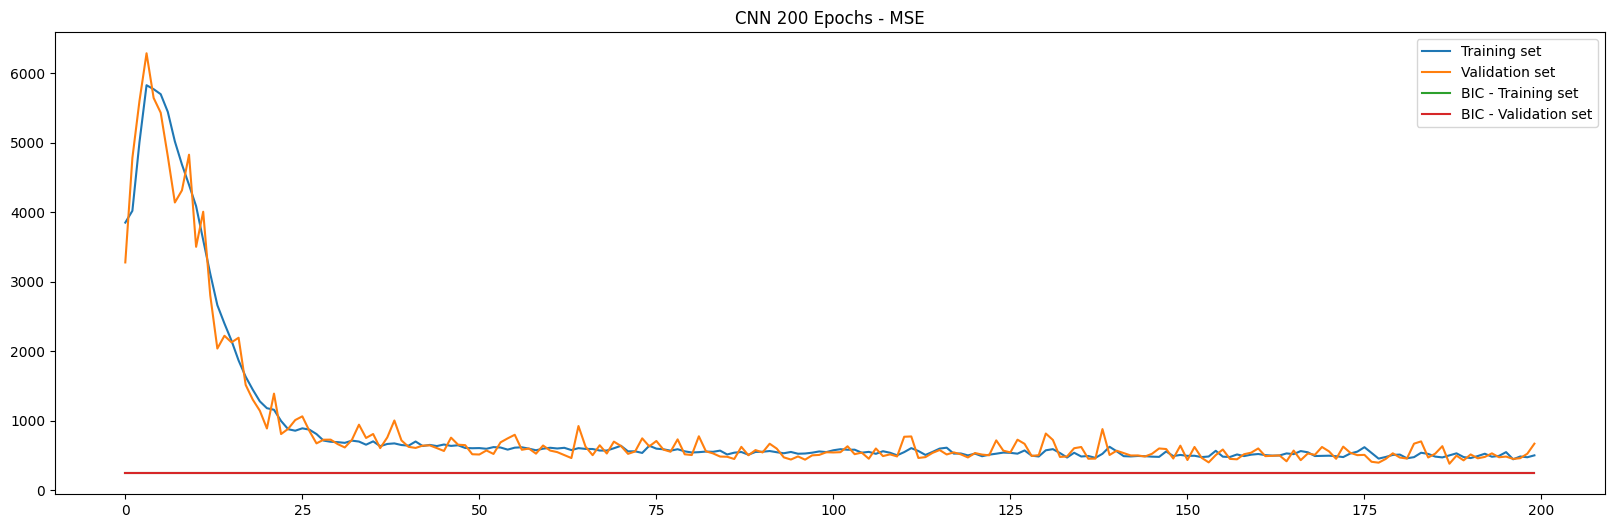

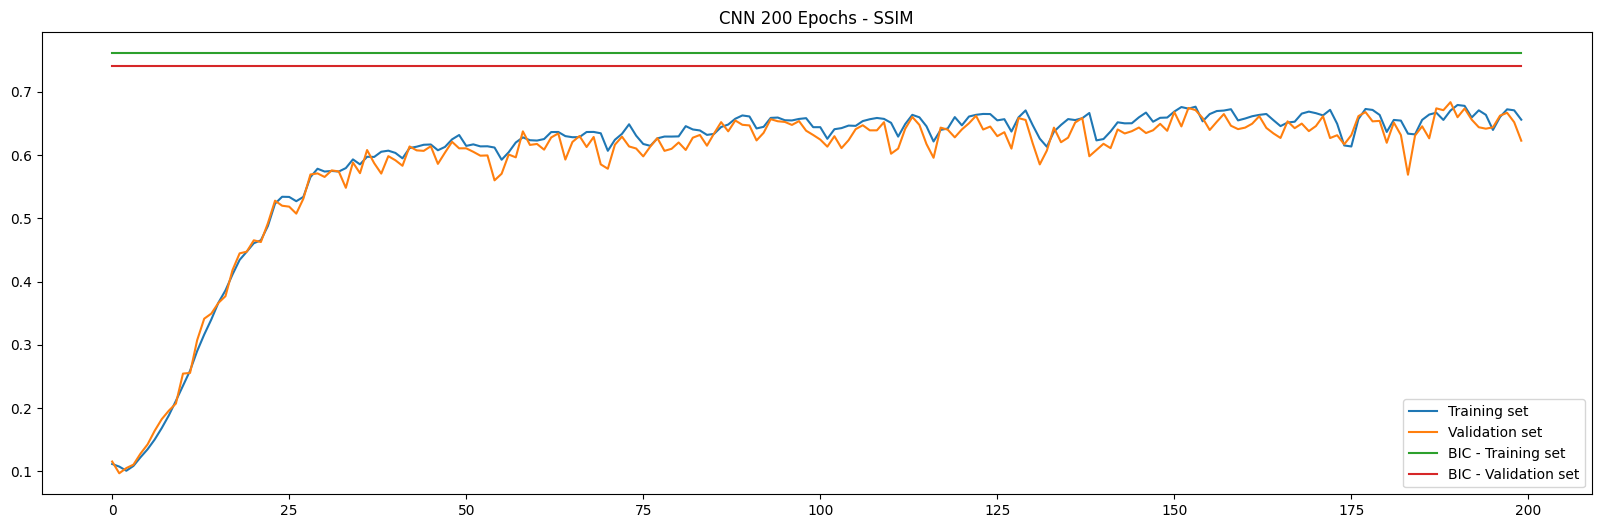

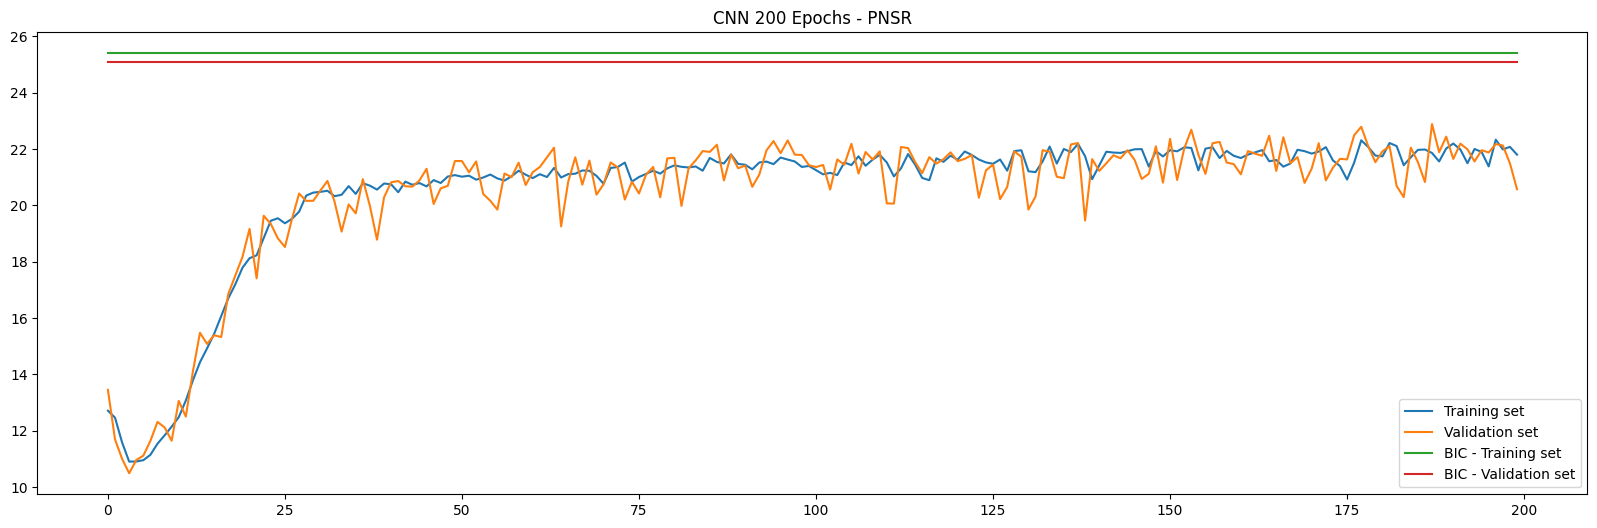

In [14]:
import matplotlib.pyplot as plt

train_mse_gen = []
train_mse_bic = []

train_ssim_gen = []
train_ssim_bic = []

train_psnr_gen = []
train_psnr_bic = []

for i in range(number_of_epochs):
  train_mse_gen.append(loaded_df_train[f'EPOCH_{i+1}']['GEN_MSE'].mean())
  train_mse_bic.append(loaded_df_train[f'EPOCH_{i+1}']['BIC_MSE'].mean())

  train_ssim_gen.append(loaded_df_train[f'EPOCH_{i+1}']['GEN_SSIM'].mean())
  train_ssim_bic.append(loaded_df_train[f'EPOCH_{i+1}']['BIC_SSIM'].mean())
  
  train_psnr_gen.append(loaded_df_train[f'EPOCH_{i+1}']['GEN_PSNR'].mean())
  train_psnr_bic.append(loaded_df_train[f'EPOCH_{i+1}']['BIC_PSNR'].mean())


valid_mse_gen = []
valid_mse_bic = []

valid_ssim_gen = []
valid_ssim_bic = []

valid_psnr_gen = []
valid_psnr_bic = []
for i in range(number_of_epochs):
  valid_mse_gen.append(loaded_df_valid[f'EPOCH_{i+1}']['GEN_MSE'].mean())
  valid_mse_bic.append(loaded_df_valid[f'EPOCH_{i+1}']['BIC_MSE'].mean())
  
  valid_ssim_gen.append(loaded_df_valid[f'EPOCH_{i+1}']['GEN_SSIM'].mean())
  valid_ssim_bic.append(loaded_df_valid[f'EPOCH_{i+1}']['BIC_SSIM'].mean())
  
  valid_psnr_gen.append(loaded_df_valid[f'EPOCH_{i+1}']['GEN_PSNR'].mean())
  valid_psnr_bic.append(loaded_df_valid[f'EPOCH_{i+1}']['BIC_PSNR'].mean())

title = ''

# MSE
plt.figure(figsize=(20,6))
plt.title(f'CNN {number_of_epochs} Epochs - MSE')
plt.plot(np.arange(len(train_mse_gen)), train_mse_gen, label='Training set')
plt.plot(np.arange(len(valid_mse_gen)), valid_mse_gen, label='Validation set')
plt.plot(np.arange(len(train_mse_bic)), train_mse_bic, label='BIC - Training set')
plt.plot(np.arange(len(valid_mse_bic)), valid_mse_bic, label='BIC - Validation set')
plt.legend()
plt.show()

# SSIM
plt.figure(figsize=(20,6))
plt.title(f'CNN {number_of_epochs} Epochs - SSIM')
plt.plot(np.arange(len(train_ssim_gen)), train_ssim_gen, label='Training set')
plt.plot(np.arange(len(valid_ssim_gen)), valid_ssim_gen, label='Validation set')
plt.plot(np.arange(len(train_ssim_bic)), train_ssim_bic, label='BIC - Training set')
plt.plot(np.arange(len(valid_ssim_bic)), valid_ssim_bic, label='BIC - Validation set')
plt.legend()
plt.show()

# PSNR
plt.figure(figsize=(20,6))
plt.title(f'CNN {number_of_epochs} Epochs - PNSR')
plt.plot(np.arange(len(train_psnr_gen)), train_psnr_gen, label='Training set')
plt.plot(np.arange(len(valid_psnr_gen)), valid_psnr_gen, label='Validation set')
plt.plot(np.arange(len(train_psnr_bic)), train_psnr_bic, label='BIC - Training set')
plt.plot(np.arange(len(valid_psnr_bic)), valid_psnr_bic, label='BIC - Validation set')
plt.legend()
plt.show()

In [ ]:
loaded_df_valid[f'EPOCH_{number_of_epochs}']['BIC_PSNR']
loaded_df_valid[f'EPOCH_{number_of_epochs}']['GEN_PSNR']

number_of_epochs = 200

epoch_p = 1
best_psnr = loaded_df_valid[f'EPOCH_1']['GEN_PSNR']
epoch_s = 1
best_ssim = loaded_df_valid[f'EPOCH_1']['GEN_SSIM']
epoch_m = 1
best_mse = loaded_df_valid[f'EPOCH_1']['GEN_MSE']
for i in range(number_of_epochs):
  a = loaded_df_valid[f'EPOCH_{i+1}']['GEN_PSNR'].mean()
  if a > best_psnr.mean():
    best_psnr = loaded_df_valid[f'EPOCH_{i+1}']['GEN_PSNR']
    epoch_p = i+1

  if loaded_df_valid[f'EPOCH_{i+1}']['GEN_SSIM'].mean() > best_ssim.mean():
    best_ssim = loaded_df_valid[f'EPOCH_{i+1}']['GEN_SSIM']
    epoch_s = i+1

  if loaded_df_valid[f'EPOCH_{i+1}']['GEN_MSE'].mean() < best_mse.mean():
    best_mse = loaded_df_valid[f'EPOCH_{i+1}']['GEN_MSE']
    epoch_m = i+1

print("PSNR")
print(epoch_p)

print("SSIM")
print(epoch_s)

print("MSE")
print(epoch_m)

print(loaded_df_valid[f'EPOCH_{number_of_epochs}']['GEN_MSE'].mean())
print(loaded_df_valid[f'EPOCH_{number_of_epochs}']['BIC_MSE'].mean())
print(best_mse.mean())
print()
print(loaded_df_valid[f'EPOCH_{number_of_epochs}']['GEN_PSNR'].mean())
print(loaded_df_valid[f'EPOCH_{number_of_epochs}']['BIC_PSNR'].mean())
print(best_psnr.mean())
print()
print(loaded_df_valid[f'EPOCH_{number_of_epochs}']['GEN_SSIM'].mean())
print(loaded_df_valid[f'EPOCH_{number_of_epochs}']['BIC_SSIM'].mean())
print(best_ssim.mean())

PSNR
188
SSIM
190
MSE
188
669.5632397999999
244.66292341000005
380.87250135

20.571523225
25.092213540000003
22.884932

0.6228072516000001
0.7406806853999999
0.6836965117000001


In [ ]:
psnr_arr = [[], []]
psnr_arr[0] = loaded_df_valid['EPOCH_200']['BIC_PSNR']
psnr_arr[1] = loaded_df_valid['EPOCH_200']['GEN_PSNR']

ssim_arr = [[], []]
ssim_arr[0] = loaded_df_valid['EPOCH_200']['BIC_SSIM']
ssim_arr[1] = loaded_df_valid['EPOCH_200']['GEN_SSIM']

mse_arr = [[], []]
mse_arr[0] = loaded_df_valid['EPOCH_200']['BIC_MSE']
mse_arr[1] = loaded_df_valid['EPOCH_200']['GEN_MSE']

print('CNN - Results')
print('PSNR')
greater_than = psnr_arr[0] < psnr_arr[1]
percentage = np.mean(greater_than) * 100
print(percentage)
print('')

print('SSIM')
greater_than = ssim_arr[0] < ssim_arr[1]
percentage = np.mean(greater_than) * 100
print(percentage)
print('')

print('MSE')
greater_than = mse_arr[0] > mse_arr[1]
percentage = np.mean(greater_than) * 100
print(percentage)
print('')
print('')

CNN - Results
PSNR
4.0

SSIM
0.0

MSE
4.0




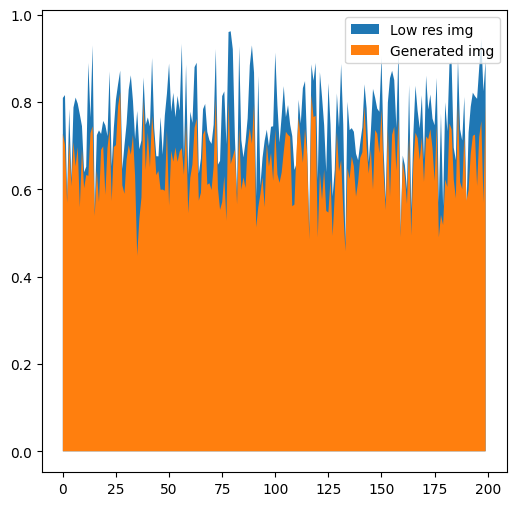

In [ ]:

x = loaded_df_train[f'EPOCH_{number_of_epochs}']['BIC_SSIM']
x2 = loaded_df_train[f'EPOCH_{number_of_epochs}']['GEN_SSIM']
mean = x.mean()
std = x.std()
y = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))

#mean2 = loaded_df_train[f'EPOCH_{number_of_epochs}']['GEN_MSE'].mean()
#std2 = loaded_df_train[f'EPOCH_{number_of_epochs}']['GEN_MSE'].std()

plt.figure(figsize = (6, 6))
plt.fill_between(np.arange(x.size), x, label = "Low res img")
plt.fill_between(np.arange(x2.size), x2, label = "Generated img")
plt.legend()

#plt.errorbar([1], [mean2], [std2])
plt.show()